<a name="top"></a>
# **HW15 Meta Learning: Few-shot Classification**

This is the sample code for homework 15.

Please mail to mlta-2022-spring@googlegroups.com if you have any questions.

## **Step 1: Download Data**

Run the cell to download data, which has been pre-processed by TAs.  
The dataset has been augmented, so extra data augmentation is not required.


In [1]:
workspace_dir = '.'

# Download dataset
# !wget https://github.com/xraychen/shiny-disco/releases/download/Latest/omniglot.tar.gz \
#     -O "{workspace_dir}/Omniglot.tar.gz"
# !wget https://github.com/xraychen/shiny-disco/releases/download/Latest/omniglot-test.tar.gz \
#     -O "{workspace_dir}/Omniglot-test.tar.gz"

# # Use `tar' command to decompress
# !tar -zxf "{workspace_dir}/Omniglot.tar.gz" -C "{workspace_dir}/"
# !tar -zxf "{workspace_dir}/Omniglot-test.tar.gz" -C "{workspace_dir}/"

## **Step 2: Build the model**

### Library importation

In [2]:
# Import modules we need
import glob, random
from collections import OrderedDict

import numpy as np
from tqdm.auto import tqdm

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

from PIL import Image
from IPython.display import display

# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"DEVICE = {device}")

# Fix random seeds
random_seed = 900405
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

DEVICE = cuda


### Model Construction Preliminaries

Since our task is image classification, we need to build a CNN-based model.  
However, to implement MAML algorithm, we should adjust some code in `nn.Module`.


Take a look at MAML pseudocode...

<img src="https://i.imgur.com/9aHlvfX.png" width="50%" />

On the 10-th line, what we take gradients on are those $\theta$ representing  
<font color="#0CC">**the original model parameters**</font> (outer loop) instead of those in  the  
<font color="#0C0">**inner loop**</font>, so we need to use `functional_forward` to compute the output  
logits of input image instead of `forward` in `nn.Module`.

The following defines these functions.

<!-- 由於在第10行，我們是要對原本的參數 θ 微分，並非 inner-loop (Line5~8) 的 θ' 微分，因此在 inner-loop，我們需要用 functional forward 的方式算出 input image 的 output logits，而不是直接用 nn.module 裡面的 forward（直接對 θ 微分）。在下面我們分別定義了 functional forward 以及 forward 函數。 -->

### Model block definition

In [3]:
def ConvBlock(in_ch: int, out_ch: int):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )


def ConvBlockFunction(x, w, b, w_bn, b_bn):
    x = F.conv2d(x, w, b, padding=1)
    x = F.batch_norm(
        x, running_mean=None, running_var=None, weight=w_bn, bias=b_bn, training=True
    )
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2)
    return x

### Model definition

In [4]:
class Classifier(nn.Module):
    def __init__(self, in_ch, k_way):
        super(Classifier, self).__init__()
        self.conv1 = ConvBlock(in_ch, 64)
        self.conv2 = ConvBlock(64, 64)
        self.conv3 = ConvBlock(64, 64)
        self.conv4 = ConvBlock(64, 64)
        self.logits = nn.Linear(64, k_way)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.shape[0], -1)
        x = self.logits(x)
        return x

    def functional_forward(self, x, params):
        """
        Arguments:
        x: input images [batch, 1, 28, 28]
        params: model parameters,
                i.e. weights and biases of convolution
                     and weights and biases of
                                   batch normalization
                type is an OrderedDict

        Arguments:
        x: input images [batch, 1, 28, 28]
        params: The model parameters,
                i.e. weights and biases of convolution
                     and batch normalization layers
                It's an `OrderedDict`
        """
        for block in [1, 2, 3, 4]:
            x = ConvBlockFunction(
                x,
                params[f"conv{block}.0.weight"],
                params[f"conv{block}.0.bias"],
                params.get(f"conv{block}.1.weight"),
                params.get(f"conv{block}.1.bias"),
            )
        x = x.view(x.shape[0], -1)
        x = F.linear(x, params["logits.weight"], params["logits.bias"])
        return x

### Create Label

This function is used to create labels.  
In a N-way K-shot few-shot classification problem,
each task has `n_way` classes, while there are `k_shot` images for each class.  
This is a function that creates such labels.


In [5]:
def create_label(n_way, k_shot):
    return torch.arange(n_way).repeat_interleave(k_shot).long()


# Try to create labels for 5-way 2-shot setting
create_label(5, 2)

tensor([0, 0, 1, 1, 2, 2, 3, 3, 4, 4])

### Accuracy calculation

In [6]:
def calculate_accuracy(logits, labels):
    """utility function for accuracy calculation"""
    acc = np.asarray(
        [(torch.argmax(logits, -1).cpu().numpy() == labels.cpu().numpy())]
    ).mean()
    return acc

### Define Dataset

Define the dataset.  
The dataset returns images of a random character, with (`k_shot + q_query`) images,  
so the size of returned tensor is `[k_shot+q_query, 1, 28, 28]`.  


In [7]:
# Dataset for train and val
class Omniglot(Dataset):
    def __init__(self, data_dir, k_way, q_query, task_num=None):
        self.file_list = [
            f for f in glob.glob(data_dir + "**/character*", recursive=True)
        ]
        # limit task number if task_num is set
        if task_num is not None:
            self.file_list = self.file_list[: min(len(self.file_list), task_num)]
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.n = k_way + q_query

    def __getitem__(self, idx):
        sample = np.arange(20)

        # For random sampling the characters we want.
        np.random.shuffle(sample)
        img_path = self.file_list[idx]
        img_list = [f for f in glob.glob(img_path + "**/*.png", recursive=True)]
        img_list.sort()
        imgs = [self.transform(Image.open(img_file)) for img_file in img_list]
        # `k_way + q_query` examples for each character
        imgs = torch.stack(imgs)[sample[: self.n]]
        return imgs

    def __len__(self):
        return len(self.file_list)

## **Step 3: Learning Algorithms**


### Meta Learning

Here is the main Meta Learning algorithm.

Please finish the TODO blocks for the inner and outer loop update rules.

- For implementing FO-MAML you can refer to [p.25 of the slides](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2019/Lecture/Meta1%20(v6).pdf#page=25&view=FitW).

- For the original MAML, you can refer to [the slides of meta learning (p.13 ~ p.18)](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2019/Lecture/Meta1%20(v6).pdf#page=13&view=FitW).


In [8]:
def inner_update(fast_weights, loss, inner_lr):
    grads = torch.autograd.grad(
        loss, list(fast_weights.values())[-2:], create_graph=True)
    # Split out the logits
    for ((name, param), grad) in zip(
        list(fast_weights.items())[-2:], grads):
        fast_weights[name] = param - inner_lr * grad
    return fast_weights

In [9]:
def collect_gradients(
    special_grad: OrderedDict, fast_weights, model, len_data):
    diff = OrderedDict(
        (name, params - fast_weights[name]) 
        for (name, params) in model.named_parameters())
    for name in diff:
        special_grad[name] = special_grad.get(name, 0) + diff[name] / len_data
    return special_grad

In [10]:
def outer_update(model, meta_batch_loss, grad_tensors):
    meta_batch_loss.backward()

In [11]:
def MetaSolver(
    model,
    optimizer,
    x,
    n_way,
    k_shot,
    q_query,
    loss_fn,
    inner_train_step=1,
    inner_lr=0.4,
    train=True,
    return_labels=False
):
    criterion, task_loss, task_acc = loss_fn, [], []
    labels = []
    special_grad = OrderedDict() 

    for meta_batch in x:
        # Get data
        support_set = meta_batch[: n_way * k_shot]
        query_set = meta_batch[n_way * k_shot :]

        # Copy the params for inner loop
        fast_weights = OrderedDict(model.named_parameters())

        ### ---------- INNER TRAIN LOOP ---------- ###
        for inner_step in range(inner_train_step):
            # Simply training
            train_label = create_label(n_way, k_shot).to(device)
            logits = model.functional_forward(support_set, fast_weights)
            loss = criterion(logits, train_label)
            # Inner gradients update! vvvvvvvvvvvvvvvvvvvv #
            """ Inner Loop Update """
            # TODO: Finish the inner loop update rule
            fast_weights = inner_update(fast_weights, loss, inner_lr)
            # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ #

        ### ---------- INNER VALID LOOP ---------- ###
        if not return_labels:
            """ training / validation """
            val_label = create_label(n_way, q_query).to(device)
            # special_grad = collect_gradients(special_grad, fast_weights, model, len(x))

            # Collect gradients for outer loop
            logits = model.functional_forward(query_set, fast_weights)
            loss = criterion(logits, val_label)
            task_loss.append(loss)
            task_acc.append(calculate_accuracy(logits, val_label))
        else:
            """ testing """
            logits = model.functional_forward(query_set, fast_weights)
            labels.extend(torch.argmax(logits, -1).cpu().numpy())

    if return_labels:
        return labels

    # Update outer loop
    model.train()
    optimizer.zero_grad()

    meta_batch_loss = torch.stack(task_loss).mean()
    if train:
        """ Outer Loop Update """
        # TODO: Finish the outer loop update
        outer_update(model, meta_batch_loss, special_grad)
        optimizer.step()

    task_acc = np.mean(task_acc)
    return meta_batch_loss, task_acc

## **Step 4: Initialization**

After defining all components we need, the following initialize a model before training.

### Hyperparameters 

In [12]:
n_way = 5
k_shot = 1
q_query = 1
train_inner_train_step = 1
val_inner_train_step = 3
inner_lr = 0.4
meta_lr = 0.001
meta_batch_size = 32
max_epoch = 100
eval_batches = 20
train_data_path = "./Omniglot/images_background/"

### Dataloader initialization

In [13]:
def dataloader_init(datasets, shuffle=True, num_workers=2):
    train_set, val_set = datasets
    train_loader = DataLoader(
        train_set,
        # The "batch_size" here is not \
        #    the meta batch size, but  \
        #    how many different        \
        #    characters in a task,     \
        #    i.e. the "n_way" in       \
        #    few-shot classification.
        batch_size=n_way,
        num_workers=num_workers,
        shuffle=shuffle,
        drop_last=True,
    )
    val_loader = DataLoader(
        val_set, batch_size=n_way, num_workers=num_workers, shuffle=shuffle, drop_last=True
    )

    train_iter = iter(train_loader)
    val_iter = iter(val_loader)
    return (train_loader, val_loader), (train_iter, val_iter)

### Model & optimizer initialization

In [14]:
def model_init():
    meta_model = Classifier(1, n_way).to(device)
    optimizer = torch.optim.Adam(meta_model.parameters(), lr=meta_lr)
    loss_fn = nn.CrossEntropyLoss().to(device)
    return meta_model, optimizer, loss_fn

### Utility function to get a meta-batch

In [15]:
def get_meta_batch(meta_batch_size, k_shot, q_query, data_loader, iterator):
    data = []
    for _ in range(meta_batch_size):
        try:
            # a "task_data" tensor is representing \
            #     the data of a task, with size of \
            #     [n_way, k_shot+q_query, 1, 28, 28]
            task_data = iterator.next()
        except StopIteration:
            iterator = iter(data_loader)
            task_data = iterator.next()
        train_data = task_data[:, :k_shot].reshape(-1, 1, 28, 28)
        val_data = task_data[:, k_shot:].reshape(-1, 1, 28, 28)
        task_data = torch.cat((train_data, val_data), 0)
        data.append(task_data)
    return torch.stack(data).to(device), iterator

<a name="mainprog" id="mainprog"></a>
## **Step 5: Main program for training & testing**

## Report part

In [16]:
# task_num_list = []
# accuracy_list = []

# for task_num in range(50, 850, 50):
#     meta_model, optimizer, loss_fn = model_init()
#     Solver = MetaSolver
#     dataset = Omniglot(train_data_path, k_shot, q_query, task_num)
#     train_split = int(0.8 * len(dataset))
#     val_split = len(dataset) - train_split
#     train_set, val_set = torch.utils.data.random_split(
#         dataset, [train_split, val_split]
#     )
#     (train_loader, val_loader), (train_iter, val_iter) = dataloader_init((train_set, val_set))

#     acc_mean = []

#     # main training loop
#     for epoch in range(max_epoch):
#         print("Epoch %d" % (epoch + 1))
#         train_meta_loss = []
#         train_acc = []
#         # The "step" here is a meta-gradinet update step
#         for step in range(max(1, len(train_loader) // meta_batch_size)):
#             x, train_iter = get_meta_batch(
#                 meta_batch_size, k_shot, q_query, train_loader, train_iter
#             )
#             meta_loss, acc = Solver(
#                 meta_model,
#                 optimizer,
#                 x,
#                 n_way,
#                 k_shot,
#                 q_query,
#                 loss_fn, 
#                 inner_train_step=train_inner_train_step
#             )
#             train_meta_loss.append(meta_loss.item())
#             train_acc.append(acc)
#         print("  Loss    : ", "%.3f" % (np.mean(train_meta_loss)), end="\t")
#         print("  Accuracy: ", "%.3f %%" % (np.mean(train_acc) * 100))

#         # See the validation accuracy after each epoch.
#         # Early stopping is welcomed to implement.
#         val_acc = []
#         for eval_step in range(max(1, len(val_loader) // (eval_batches))):
#             x, val_iter = get_meta_batch(
#                 eval_batches, k_shot, q_query, val_loader, val_iter
#             )
#             # We update three inner steps when testing.
#             _, acc = Solver(
#                 meta_model,
#                 optimizer,
#                 x,
#                 n_way,
#                 k_shot,
#                 q_query,
#                 loss_fn,
#                 inner_train_step=val_inner_train_step,
#                 train=False,
#             )
#             val_acc.append(acc)
#         print("  Validation accuracy: ", "%.3f %%" % (np.mean(val_acc) * 100))
#         if epoch >= max_epoch - 100 and epoch <= max_epoch - 1:
#             acc_mean.append(np.mean(val_acc))
            
#     accuracy_list.append(sum(acc_mean) / len(acc_mean))
#     task_num_list.append(task_num)

In [17]:
# import matplotlib.pyplot as plt
# import pandas as pd

# plt.plot(task_num_list, accuracy_list)
# plt.xlabel('number of tasks')
# plt.ylabel('dev accuracy')
# plt.show()

In [18]:
meta_model, optimizer, loss_fn = model_init()

Solver = MetaSolver
dataset = Omniglot(train_data_path, k_shot, q_query)
train_split = int(0.8 * len(dataset))
val_split = len(dataset) - train_split
train_set, val_set = torch.utils.data.random_split(
    dataset, [train_split, val_split]
)
(train_loader, val_loader), (train_iter, val_iter) = dataloader_init((train_set, val_set))


val_inner_train_step_list = []
val_accuracy_list = []

# main training loop
for val_inner_train_step in range(1, 10):
    for epoch in range(max_epoch):
        print("Epoch %d" % (epoch + 1))
        train_meta_loss = []
        train_acc = []
        # The "step" here is a meta-gradinet update step
        for step in range(max(1, len(train_loader) // meta_batch_size)):
            x, train_iter = get_meta_batch(
                meta_batch_size, k_shot, q_query, train_loader, train_iter
            )
            meta_loss, acc = Solver(
                meta_model,
                optimizer,
                x,
                n_way,
                k_shot,
                q_query,
                loss_fn, 
                inner_train_step=train_inner_train_step
            )
            train_meta_loss.append(meta_loss.item())
            train_acc.append(acc)
        # print("  Loss    : ", "%.3f" % (np.mean(train_meta_loss)), end="\t")
        # print("  Accuracy: ", "%.3f %%" % (np.mean(train_acc) * 100))

        # See the validation accuracy after each epoch.
        # Early stopping is welcomed to implement.
        val_acc = []
        for eval_step in range(max(1, len(val_loader) // (eval_batches))):
            x, val_iter = get_meta_batch(
                eval_batches, k_shot, q_query, val_loader, val_iter
            )
            # We update three inner steps when testing.
            _, acc = Solver(
                meta_model,
                optimizer,
                x,
                n_way,
                k_shot,
                q_query,
                loss_fn,
                inner_train_step=val_inner_train_step,
                train=False,
            )
            val_acc.append(acc)
            del x
        del acc
        del _
        torch.cuda.empty_cache()
        val_inner_train_step_list.append(val_inner_train_step)
        print("Step: %d" % (val_inner_train_step))
        print("Validation accuracy: ", "%.3f %%" % (np.mean(val_acc) * 100))
        val_accuracy_list.append(np.mean(val_acc))

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Step: 1
Validation accuracy:  93.000 %
Step: 2
Validation accuracy:  95.000 %
Step: 3
Validation accuracy:  

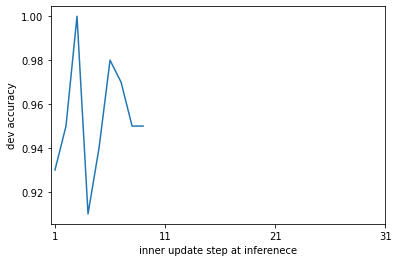

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

plt.plot(val_inner_train_step_list, val_accuracy_list)
plt.xlabel('inner update step at inferenece')
plt.ylabel('dev accuracy')
plt.xticks(range(1, 10, 1))
plt.show()

## **Reference**
1. Chelsea Finn, Pieter Abbeel, & Sergey Levine. (2017). [Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks.](https://arxiv.org/abs/1909.09157)
1. Aniruddh Raghu, Maithra Raghu, Samy Bengio, & Oriol Vinyals. (2020). [Rapid Learning or Feature Reuse? Towards Understanding the Effectiveness of MAML.](https://arxiv.org/abs/1909.09157)